# Regresja logistyczna

## Zadanie na 3

Porównanie sklearn i własnej implementacji klasyfikatora na syntetycznych zbiorach

#### Import bibliotek

In [406]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#### Funkcje do oceny skuteczności

In [407]:
def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Macierz Pomyłek")
    plt.show()

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy, sensitivity, specificity

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Losowa klasyfikacja')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Krzywa ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_dataset(X, y, title="Dataset"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
        
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

#### Wygenerowanie danych 

make_classification

x (2599, 2)
y (2599,)


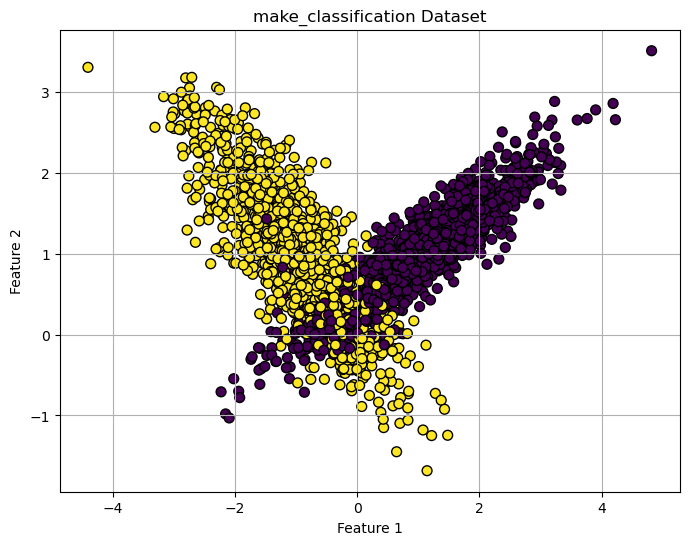

In [408]:
my_index = 259199
my_n_samples = int(str(my_index)[0]+ str(my_index)[1] + str(my_index)[-2] + str(my_index)[-1])
X_classification, y_classification = make_classification(
    n_samples=my_n_samples, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    random_state=my_index,
)

print('x', X_classification.shape)
print('y', y_classification.shape)
plot_dataset(X_classification, y_classification, title="make_classification Dataset")

make_moons

X_moons (2599, 2)
y_moons (2599,)


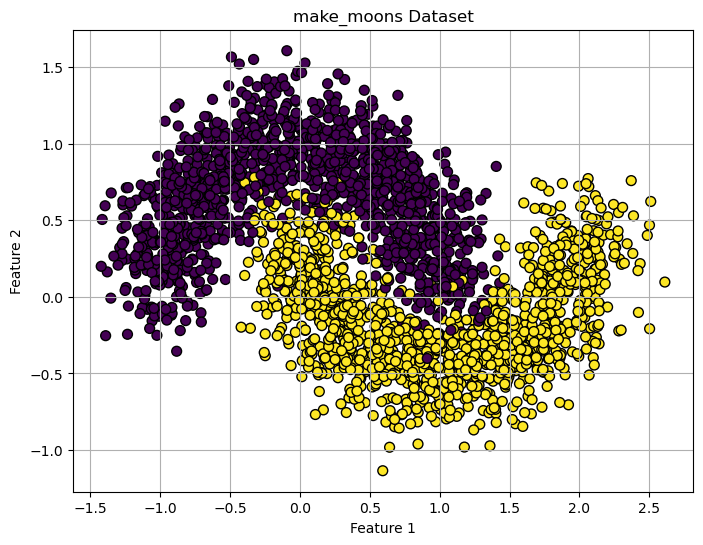

In [409]:
X_moons, y_moons = make_moons(n_samples=my_n_samples, noise=0.2, random_state=my_index)

print('X_moons', X_moons.shape)
print('y_moons', y_moons.shape)
plot_dataset(X_moons, y_moons, title="make_moons Dataset")

#### Podział danych na treningowe i testowe

In [410]:
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=my_index
)

X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=my_index
)

print('classification', X_train_classification.shape, y_train_classification.shape, X_test_classification.shape, y_test_classification.shape)
print('moons', X_train_moons.shape, y_train_moons.shape, X_test_moons.shape, y_test_moons.shape)

classification (2079, 2) (2079,) (520, 2) (520,)
moons (2079, 2) (2079,) (520, 2) (520,)


#### Logistic Regression

własna implementacja

In [411]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=0.01, beta=1.0):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.beta = beta
        self.weights = None

    def sigmoid(self, s):
        if not isinstance(s, np.ndarray):
            s = s.toarray() 
        return 1 / (1 + np.exp(-self.beta * s))

    def fit(self, X, y):
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        _, n_features = X.shape
        self.weights = np.random.rand(n_features)
        for _ in range(self.max_iter):
            linear_output = np.dot(X, self.weights)
            predictions = self.sigmoid(linear_output)
            errors = y - predictions
            gradient = -np.dot(X.T, errors * predictions * (1 - predictions))
            self.weights -= self.learning_rate * gradient
            if np.linalg.norm(gradient) < self.tol:
                break

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        linear_output = np.dot(X, self.weights)
        probabilities = self.sigmoid(linear_output)
        return (probabilities >= 0.5).astype(int)

#### Wyniki 
dla make classifiacation

Wyniki własnej implementacji:
Czas wykonania 100: 584.8663 ms
Accuracy: 0.8961538461538462, Sensitivity: 0.9042145593869731, Specificity: 0.888030888030888


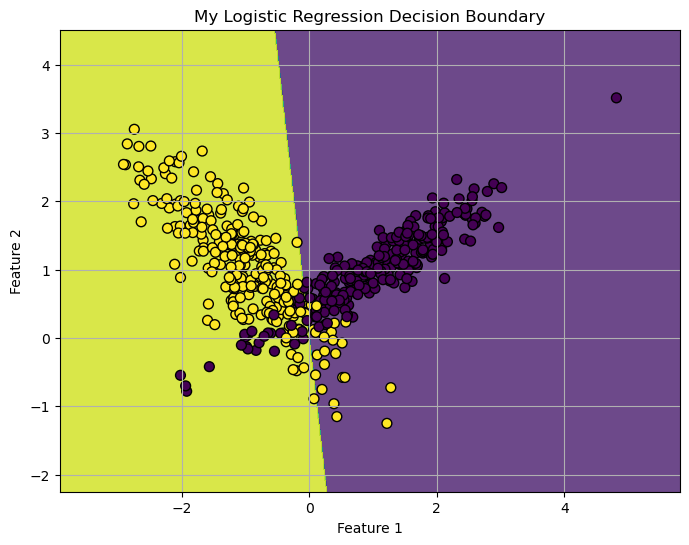

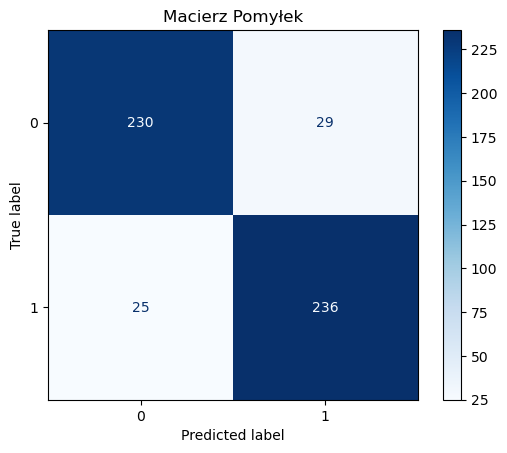

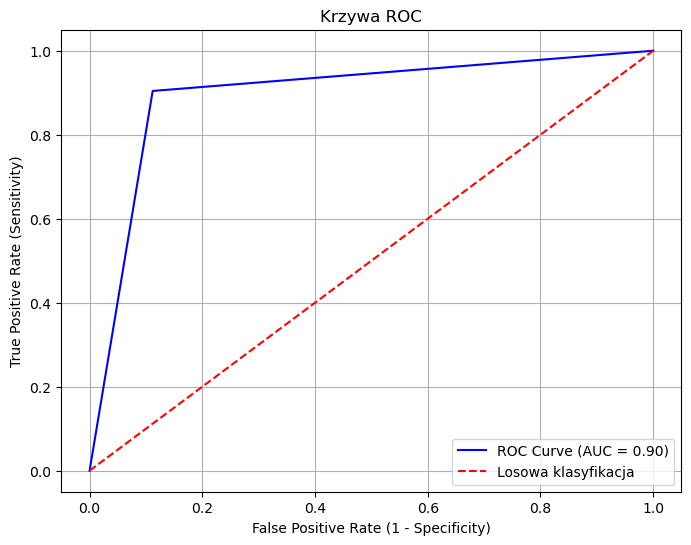


Wyniki sklearn Logistic Regression:
Czas wykonania 100: 274.2968 ms
Accuracy: 0.8923076923076924, Sensitivity: 0.9042145593869731, Specificity: 0.8803088803088803


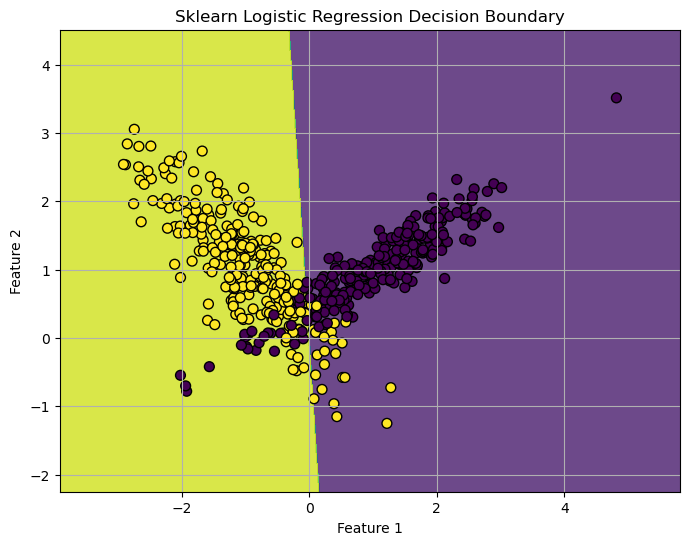

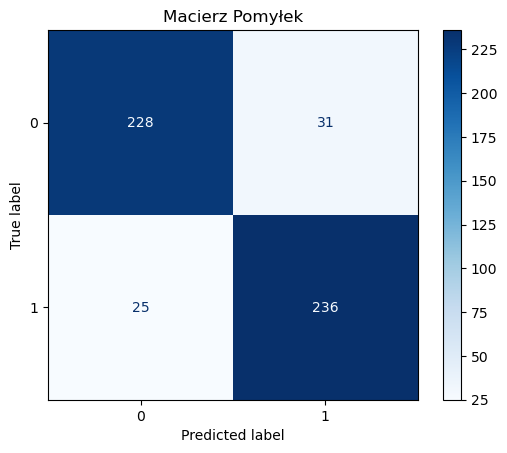

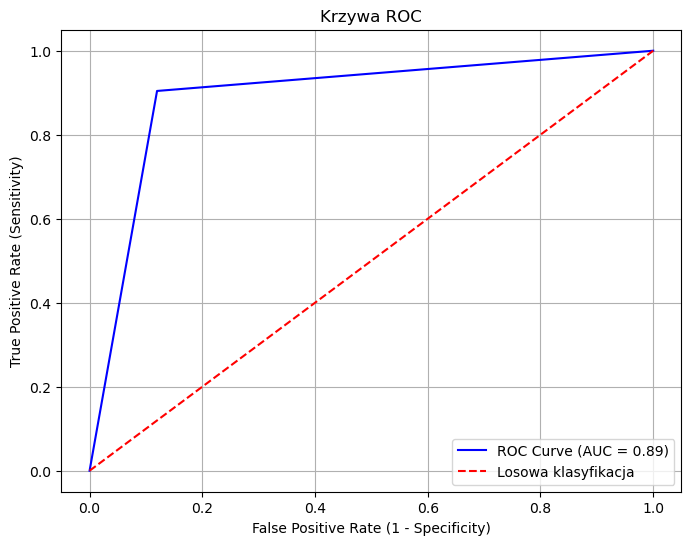

In [412]:
start_my_lr = time.time()
for _ in range(100):
    my_lr = MyLogisticRegression(learning_rate=0.01, max_iter=1000, tol=0.0001)
    my_lr.fit(X_train_classification, y_train_classification)
    y_pred_my_lr = my_lr.predict(X_test_classification)
end_my_lr = time.time()

start_sklearn_lr = time.time()
for _ in range(100):
    sklearn_lr = LogisticRegression(max_iter=1000, tol=0.0001)
    sklearn_lr.fit(X_train_classification, y_train_classification)
    y_pred_sklearn_lr = sklearn_lr.predict(X_test_classification)
end_sklearn_lr = time.time()

print("Wyniki własnej implementacji:")
time_my_lr = (end_my_lr - start_my_lr) * 1000 
print(f"Czas wykonania 100: {time_my_lr:.4f} ms")
accuracy_my_lr, sensitivity_my_lr, specificity_my_lr = calculate_metrics(y_test_classification, y_pred_my_lr)
print(f"Accuracy: {accuracy_my_lr}, Sensitivity: {sensitivity_my_lr}, Specificity: {specificity_my_lr}")
plot_decision_boundary(my_lr, X_test_classification, y_test_classification, title="My Logistic Regression Decision Boundary")
plot_confusion_matrix(y_test_classification, y_pred_my_lr, labels=[0, 1])
plot_roc_curve(y_test_classification, y_pred_my_lr)

print("\nWyniki sklearn Logistic Regression:")
time_sklearn_lr = (end_sklearn_lr - start_sklearn_lr) * 1000
print(f"Czas wykonania 100: {time_sklearn_lr:.4f} ms")
accuracy_sklearn_lr, sensitivity_sklearn_lr, specificity_sklearn_lr = calculate_metrics(y_test_classification, y_pred_sklearn_lr)
print(f"Accuracy: {accuracy_sklearn_lr}, Sensitivity: {sensitivity_sklearn_lr}, Specificity: {specificity_sklearn_lr}")
plot_decision_boundary(sklearn_lr, X_test_classification, y_test_classification, title="Sklearn Logistic Regression Decision Boundary")
plot_confusion_matrix(y_test_classification, y_pred_sklearn_lr, labels=[0, 1])
plot_roc_curve(y_test_classification, y_pred_sklearn_lr)

dla make moons

Wyniki własnej implementacji:
Czas wykonania 100: 1383.8284 ms
Accuracy: 0.8846153846153846, Sensitivity: 0.8832684824902723, Specificity: 0.8859315589353612


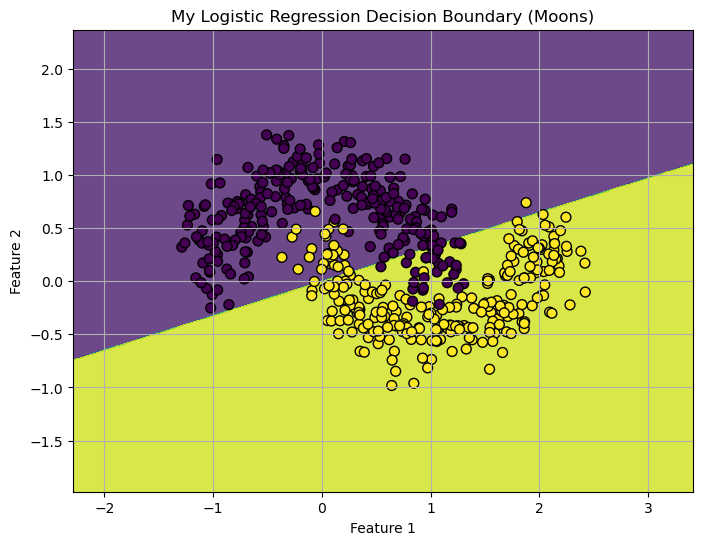

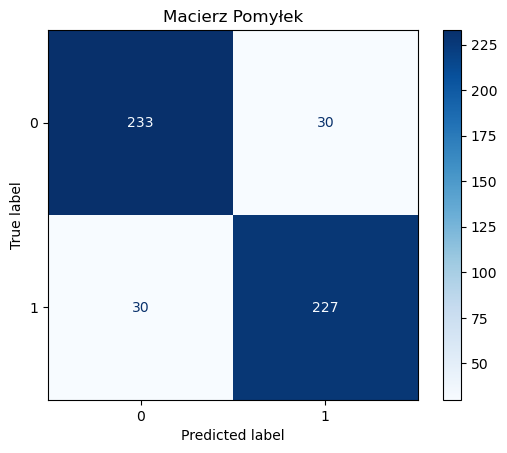

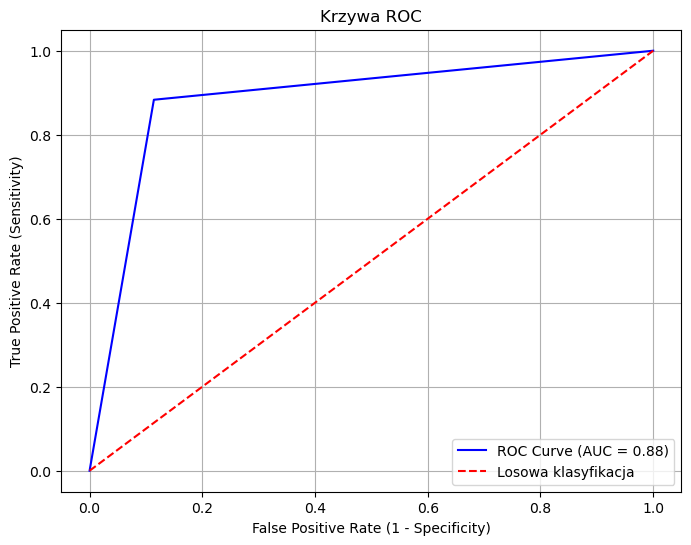


Wyniki sklearn Logistic Regression:
Czas wykonania 100:  304.9979 ms
Accuracy: 0.8788461538461538, Sensitivity: 0.9066147859922179, Specificity: 0.8517110266159695


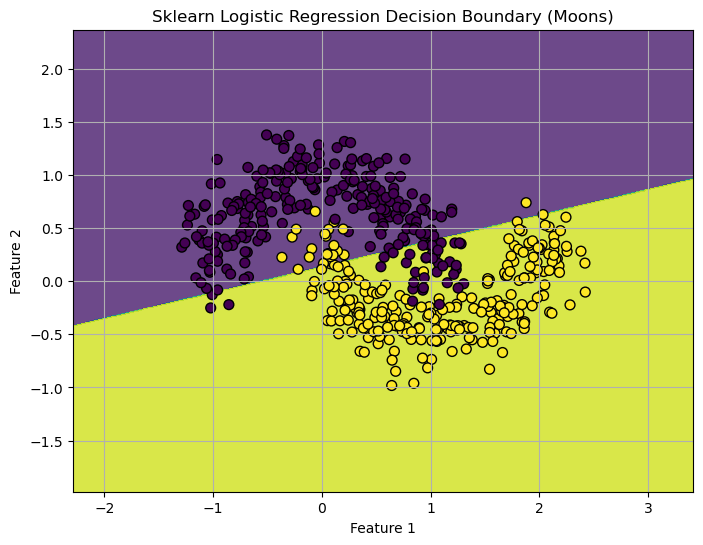

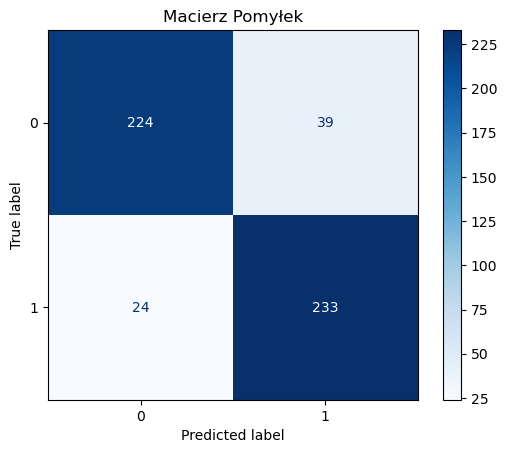

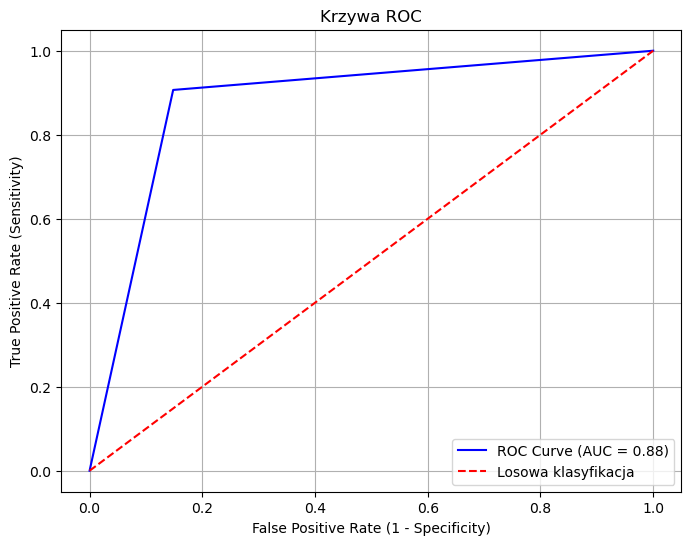

In [413]:
start_my_lr_moons = time.time()
for _ in range(100):
    my_lr_moons = MyLogisticRegression(learning_rate=0.01, max_iter=1000, tol=0.0001)
    my_lr_moons.fit(X_train_moons, y_train_moons)
    y_pred_my_lr_moons = my_lr_moons.predict(X_test_moons)
end_my_lr_moons = time.time()

start_sklearn_lr_moons = time.time()
for _ in range(100):
    sklearn_lr_moons = LogisticRegression(max_iter=1000, tol=0.0001)
    sklearn_lr_moons.fit(X_train_moons, y_train_moons)
    y_pred_sklearn_lr_moons = sklearn_lr_moons.predict(X_test_moons)
end_sklearn_lr_moons = time.time()

print("Wyniki własnej implementacji:")
time_my_lr_moons = (end_my_lr_moons - start_my_lr_moons) * 1000
print(f"Czas wykonania 100: {time_my_lr_moons:.4f} ms")
accuracy_my_lr_moons, sensitivity_my_lr_moons, specificity_my_lr_moons = calculate_metrics(y_test_moons, y_pred_my_lr_moons)
print(f"Accuracy: {accuracy_my_lr_moons}, Sensitivity: {sensitivity_my_lr_moons}, Specificity: {specificity_my_lr_moons}")
plot_decision_boundary(my_lr_moons, X_test_moons, y_test_moons, title="My Logistic Regression Decision Boundary (Moons)")
plot_confusion_matrix(y_test_moons, y_pred_my_lr_moons, labels=[0, 1])
plot_roc_curve(y_test_moons, y_pred_my_lr_moons)

print("\nWyniki sklearn Logistic Regression:")
time_sklearn_lr_moons = (end_sklearn_lr_moons - start_sklearn_lr_moons) * 1000
print(f"Czas wykonania 100:  {time_sklearn_lr_moons:.4f} ms")
accuracy_sklearn_lr_moons, sensitivity_sklearn_lr_moons, specificity_sklearn_lr_moons = calculate_metrics(y_test_moons, y_pred_sklearn_lr_moons)
print(f"Accuracy: {accuracy_sklearn_lr_moons}, Sensitivity: {sensitivity_sklearn_lr_moons}, Specificity: {specificity_sklearn_lr_moons}")
plot_decision_boundary(sklearn_lr_moons, X_test_moons, y_test_moons, title="Sklearn Logistic Regression Decision Boundary (Moons)")
plot_confusion_matrix(y_test_moons, y_pred_sklearn_lr_moons, labels=[0, 1])
plot_roc_curve(y_test_moons, y_pred_sklearn_lr_moons)

### Wnioski 

- własna implementacja jest o wiele wolniejsza

## Zadanie na 4
Poprawny preprocessing danych, nauczenie modeli dla regionów i porównanie ich skuteczności
#### Pobranie danych

In [414]:
file_path = f'./datasets/rainAUS.csv'
data = pd.read_csv(file_path)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


#### Usunięcie kolumn
Mające więcej in 30% brakujących wartości (oraz kolumnę ’Risk-MM’ jeżeli istnieje) 

In [415]:
missing_percentage = data.isnull().mean()
print("Kolumny z brakującymi wartościami powyżej 30%:\n", missing_percentage[missing_percentage > 0.3] * 100)

columns_to_drop = missing_percentage[missing_percentage > 0.3].index
data = data.drop(columns=columns_to_drop)

if 'Risk-MM' in data.columns:
    data = data.drop(columns=['Risk-MM'])

print("Pozostałe kolumny po preprocessingu:", data.columns, data.columns.shape)

Kolumny z brakującymi wartościami powyżej 30%:
 Evaporation    43.166506
Sunshine       48.009762
Cloud9am       38.421559
Cloud3pm       40.807095
dtype: float64
Pozostałe kolumny po preprocessingu: Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object') (19,)


#### Odseparowanie kolumny z wartością przewidywaną (’RainTomorrow’)

Podział na x i y

In [416]:
X = data.drop(columns=['RainTomorrow'])
y = data['RainTomorrow']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (145460, 18)
y shape: (145460,)


#### Imputacja brakujących wartości

- zmienne kategoryczne należy zastąpić dominantą 
- dane numeryczne należy zastąpić medianą

In [417]:
missing_values_before = X.isnull().sum()

categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    mode_value = X[col].mode()[0]
    X[col].fillna(mode_value, inplace=True)

numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    median_value = X[col].median()
    X[col].fillna(median_value, inplace=True)


missing_values_after = X.isnull().sum()
comparison_table = pd.DataFrame({
    'Column': X.columns,
    'Missing Before': missing_values_before.values,
    'Missing After': missing_values_after.values
})

print(comparison_table)

           Column  Missing Before  Missing After
0            Date               0              0
1        Location               0              0
2         MinTemp            1485              0
3         MaxTemp            1261              0
4        Rainfall            3261              0
5     WindGustDir           10326              0
6   WindGustSpeed           10263              0
7      WindDir9am           10566              0
8      WindDir3pm            4228              0
9    WindSpeed9am            1767              0
10   WindSpeed3pm            3062              0
11    Humidity9am            2654              0
12    Humidity3pm            4507              0
13    Pressure9am           15065              0
14    Pressure3pm           15028              0
15        Temp9am            1767              0
16        Temp3pm            3609              0
17      RainToday            3261              0


#### Winsoryzacja danych 

Odstających ponad 1.5 IQR

In [418]:
def winsorize(df, columns, iqr_multiplier=1.5):
    for col in columns:
        before_min, before_max = df[col].min(), df[col].max()

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

        after_min, after_max = df[col].min(), df[col].max()
        print(f"Winsoryzacja kolumny: {col} -> przed: {before_min} - {before_max}, po: {after_min} - {after_max}")
    return df

numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X = winsorize(X, numerical_columns)

Winsoryzacja kolumny: MinTemp -> przed: -8.5 - 33.9, po: -5.950000000000002 - 30.450000000000003
Winsoryzacja kolumny: MaxTemp -> przed: -4.8 - 48.1, po: 2.700000000000001 - 43.5
Winsoryzacja kolumny: Rainfall -> przed: 0.0 - 371.0, po: 0.0 - 1.5
Winsoryzacja kolumny: WindGustSpeed -> przed: 6.0 - 135.0, po: 8.5 - 68.5
Winsoryzacja kolumny: WindSpeed9am -> przed: 0.0 - 130.0, po: 0.0 - 37.0
Winsoryzacja kolumny: WindSpeed3pm -> przed: 0.0 - 87.0, po: 0.0 - 40.5
Winsoryzacja kolumny: Humidity9am -> przed: 0.0 - 100.0, po: 18.0 - 100.0
Winsoryzacja kolumny: Humidity3pm -> przed: 0.0 - 100.0, po: 0.0 - 100.0
Winsoryzacja kolumny: Pressure9am -> przed: 980.5 - 1041.0, po: 1001.0500000000001 - 1034.25
Winsoryzacja kolumny: Pressure3pm -> przed: 977.1 - 1039.6, po: 998.6500000000001 - 1031.85
Winsoryzacja kolumny: Temp9am -> przed: -7.2 - 40.2, po: -1.4999999999999982 - 35.3
Winsoryzacja kolumny: Temp3pm -> przed: -5.4 - 46.7, po: 2.4499999999999993 - 40.45


#### Zamiana wartości daty

In [419]:
def add_cyclic_date_features(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])

    df['DayOfYear_sin'] = np.sin(2 * np.pi * df[date_column].dt.dayofyear / 365)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df[date_column].dt.dayofyear / 365)

    return df

X = add_cyclic_date_features(X, 'Date')

X = X.drop(columns=['Date'])

X.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,DayOfYear_sin,DayOfYear_cos
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,-0.478734,0.877960
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,-0.463550,0.886071
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,-0.448229,0.893919
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,-0.432776,0.901502
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,-0.417194,0.908818


#### Usunięcie wierszy z brakiem wartości przewidywanej 

In [420]:
X['RainTomorrow'] = y

print('przed: ', X.shape, y.shape)

X = X.loc[X['RainTomorrow'].notna()]

y = X['RainTomorrow']
X = X.drop(columns=['RainTomorrow'])

print('po: ', X.shape, y.shape)

przed:  (145460, 20) (145460,)
po:  (142193, 19) (142193,)


#### Podział danych 

Podział danych dla każdego z regionów na zbiory testowe i treningowe ze stratyfikacją. 

Normalizacja danych numerycznych i kodowanie (one-hot) danych kategorycznych. 

In [421]:
x_copy = X.copy()

if 'Location' in x_copy.columns:
    x_copy = x_copy.drop(columns=['Location'])

categorical_features = x_copy.select_dtypes(include=['object']).columns.tolist()
numerical_features = x_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

preprocessor.fit(X)

regions = X['Location'].unique()
region_data = {}

for region in regions:
    region_data_subset = X[X['Location'] == region]
    region_y = y[X['Location'] == region]
    
    X_train, X_test, y_train, y_test = train_test_split(
        region_data_subset, region_y, test_size=0.2, random_state=my_index, stratify=region_y
    )
    
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    region_data[region] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

print("Liczba regionów:", len(region_data))

Liczba regionów: 49


#### Porównianie osobynch modeli dla każdego z regionów

In [422]:
region_models = {}
results = []

for region, data in region_data.items():
    model = LogisticRegression(max_iter=1000, random_state=my_index)
    model.fit(data['X_train'], data['y_train'])
    region_models[region] = model

    y_pred = model.predict(data['X_test'])
    accuracy, sensitivity, specificity = calculate_metrics(data['y_test'], y_pred)
    results.append({
        'Region': region,
        'Samples': len(data['y_train']) + len(data['y_test']),
        'Accuracy': accuracy*100,
        'Sensitivity': sensitivity*100,
        'Specificity': specificity*100,
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("")

pd.DataFrame(results_df)

,Region,Samples,Accuracy,Sensitivity,Specificity
35,Woomera,2990,94.147157,25.000000,99.103943
45,AliceSprings,3031,93.739703,42.857143,98.207885
39,PerthAirport,3009,92.857143,73.451327,97.341513
48,Uluru,1521,92.786885,56.521739,95.744681
2,Cobar,2988,92.140468,61.038961,96.737044
23,Mildura,3007,91.860465,41.538462,97.951583
40,Perth,3193,91.236307,67.441860,97.254902
4,Moree,2854,90.017513,48.101266,96.747967
0,Albury,3011,89.718076,63.709677,96.450939
38,PearceRAAF,2762,89.692586,74.257426,93.141593


Wyznaczenie regionu z najlepszą skutecznością 

In [423]:
best_region = results_df.iloc[0]['Region']
print("Najlepszy region:", best_region)

X_train_best = region_data[best_region]['X_train']
X_test_best = region_data[best_region]['X_test']
y_train_best = region_data[best_region]['y_train']
y_test_best = region_data[best_region]['y_test']

y_train_best = y_train_best.map({'Yes': 1, 'No': 0})
y_test_best = y_test_best.map({'Yes': 1, 'No': 0})

print('x', X_train_best.shape, X_test_best.shape)
print('y', y_train_best.shape, y_test_best.shape)

Najlepszy region: Woomera
x (2392, 64) (598, 64)
y (2392,) (598,)


#### Nauka sklearn

Wyniki sklearn Logistic Regression dla najlepszego regionu:
Czas wykonania 100: 3666.1353 ms
Accuracy: 0.9414715719063546, Sensitivity: 0.25, Specificity: 0.9910394265232975


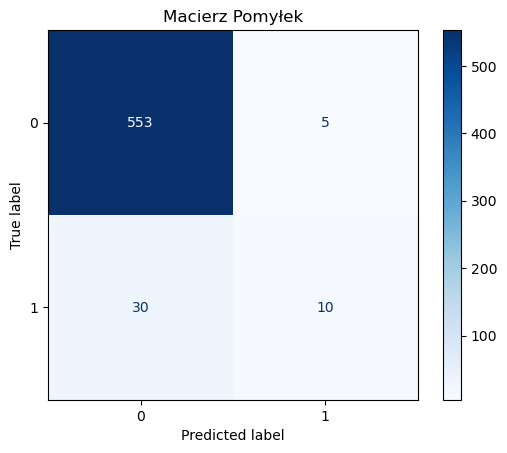

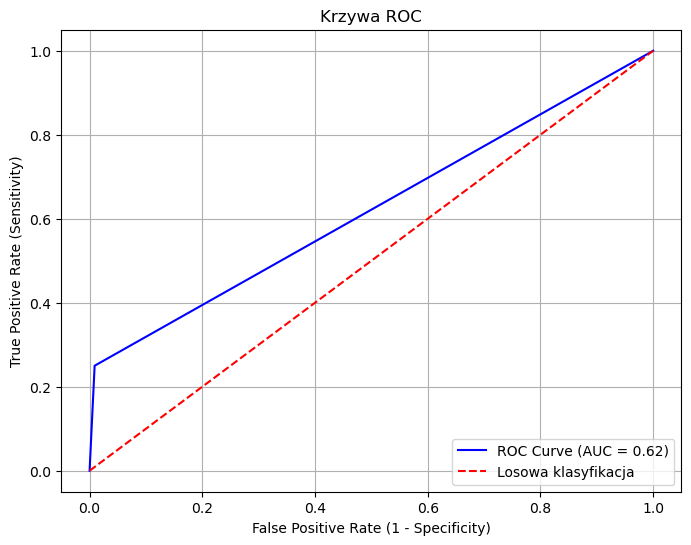

In [424]:
start_sklearn_lr = time.time()
for _ in range(100):
    sklearn_lr = LogisticRegression(max_iter=1000, tol=0.0001)
    sklearn_lr.fit(X_train_best, y_train_best)
    y_pred_sklearn_lr = sklearn_lr.predict(X_test_best)
end_sklearn_lr = time.time()

print("Wyniki sklearn Logistic Regression dla najlepszego regionu:")
time_sklearn_lr = (end_sklearn_lr - start_sklearn_lr) * 1000
print(f"Czas wykonania 100: {time_sklearn_lr:.4f} ms")
accuracy_sklearn_lr, sensitivity_sklearn_lr, specificity_sklearn_lr = calculate_metrics(y_test_best, y_pred_sklearn_lr)
print(f"Accuracy: {accuracy_sklearn_lr}, Sensitivity: {sensitivity_sklearn_lr}, Specificity: {specificity_sklearn_lr}")
plot_confusion_matrix(y_test_best, y_pred_sklearn_lr, labels=[0, 1])
plot_roc_curve(y_test_best, y_pred_sklearn_lr)

#### Nauka własnego modelu

Wyniki własnej implementacji dla najlepszego regionu:
Czas wykonania 100: 69883.4398 ms
Accuracy: 0.9414715719063546, Sensitivity: 0.275, Specificity: 0.989247311827957


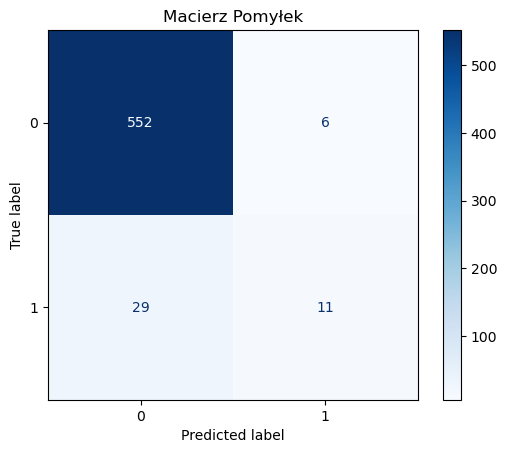

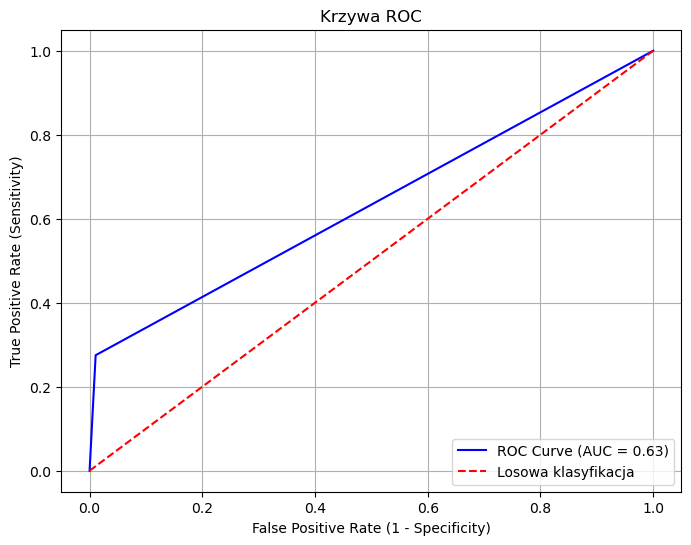

In [425]:
start_my_lr = time.time()
for _ in range(100):
    my_lr = MyLogisticRegression(learning_rate=0.01, max_iter=1000, tol=0.0001)
    my_lr.fit(X_train_best, y_train_best)
    y_pred_my_lr = my_lr.predict(X_test_best)
end_my_lr = time.time()

print("Wyniki własnej implementacji dla najlepszego regionu:")
time_my_lr = (end_my_lr - start_my_lr) * 1000
print(f"Czas wykonania 100: {time_my_lr:.4f} ms")
accuracy_my_lr, sensitivity_my_lr, specificity_my_lr = calculate_metrics(y_test_best, y_pred_my_lr)
print(f"Accuracy: {accuracy_my_lr}, Sensitivity: {sensitivity_my_lr}, Specificity: {specificity_my_lr}")
plot_confusion_matrix(y_test_best, y_pred_my_lr, labels=[0, 1])
plot_roc_curve(y_test_best, y_pred_my_lr)

### Wnioski

- najlepsze wyniki model osiąga w miejscu gdzie prawie wcale nie pada
- przez dużą ilość danych w TN są pomijane wartości z pola TP przez co czułość jest o niska

## Zadanie na 5
Weryfikacja skuteczności modeli regionalnych na zbiorze krajowym i porównanie skuteczności najlepszego modelu

### Tworzenie krajowego zbioru testowego

In [426]:
X_train_all = []
X_test_all = []
Y_train_all = []
Y_test_all = []

for region in region_data:
    X_train_all.append(region_data[region]['X_train'].toarray() if hasattr(region_data[region]['X_train'], 'toarray') else region_data[region]['X_train'])
    X_test_all.append(region_data[region]['X_test'].toarray() if hasattr(region_data[region]['X_test'], 'toarray') else region_data[region]['X_test'])
    Y_train_all.append(region_data[region]['y_train'].values)
    Y_test_all.append(region_data[region]['y_test'].values)

X_train_all = np.vstack(X_train_all)
X_test_all = np.vstack(X_test_all)
Y_train_all = np.concatenate(Y_train_all)
Y_test_all = np.concatenate(Y_test_all)

print("X_train_all shape:", X_train_all.shape)
print("X_test_all shape:", X_test_all.shape)
print("Y_train_all shape:", Y_train_all.shape)
print("Y_test_all shape:", Y_test_all.shape)

X_train_all shape: (113736, 64)
X_test_all shape: (28457, 64)
Y_train_all shape: (113736,)
Y_test_all shape: (28457,)


#### Sprawdzenie modeli regionalnych na krajowym zbiorze testowym

In [427]:
results = []

for region in regions:
    model = region_models[region]
    y_pred_all = model.predict(X_test_all)
    accuracy, sensitivity, specificity = calculate_metrics(Y_test_all, y_pred_all)
    results.append({
        'Region': region,
        'Samples': len(Y_train_all) + len(Y_test_all),
        'Accuracy': accuracy*100,
        'Sensitivity': sensitivity*100,
        'Specificity': specificity*100,
    })

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
results_df

,Region,Samples,Accuracy,Sensitivity,Specificity
14,Wollongong,142193,82.774010,39.592476,95.252978
9,Richmond,142193,82.292582,51.974922,91.054038
42,Walpole,142193,82.095794,53.652038,90.315713
1,BadgerysCreek,142193,81.993886,52.147335,90.619196
31,Townsville,142193,81.920090,34.184953,95.714998
6,NorahHead,142193,81.888463,45.250784,92.476333
20,Sale,142193,81.863865,53.620690,90.025819
44,Launceston,142193,81.663563,45.626959,92.077728
25,Portland,142193,81.656534,46.912226,91.697241
8,Penrith,142193,81.575711,52.084639,90.098292


#### Model z najlepszą skutecznością krajową

In [428]:
best_region = results_df.iloc[0]['Region']
print("Najlepszy region:", best_region)

Najlepszy region: Wollongong


#### DummyClassifier

Wyniki DummyClassifier:
Accuracy: 0.7758
Sensitivity: 0.0000
Specificity: 1.0000


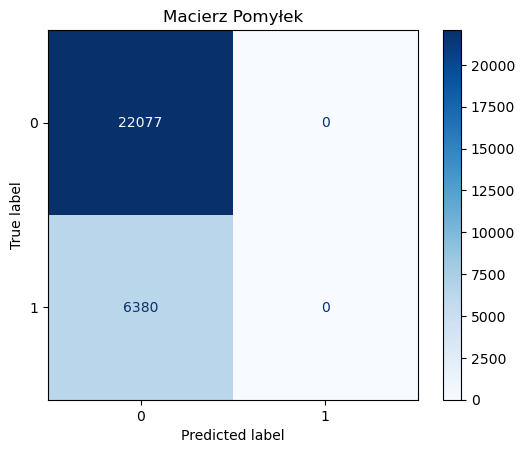

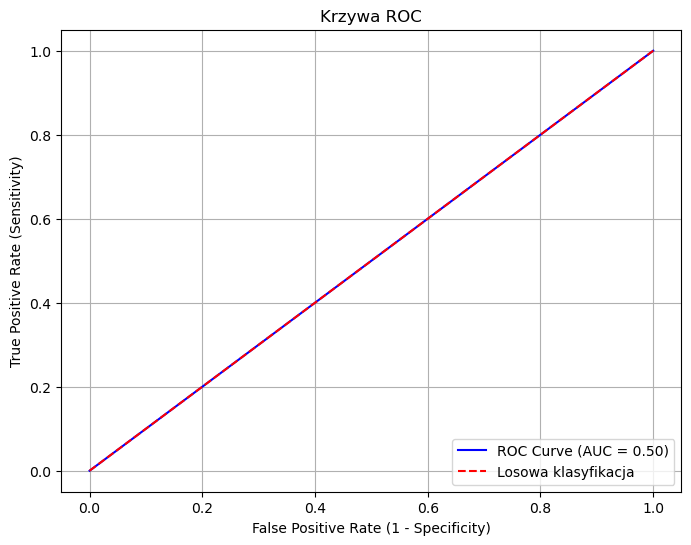

In [429]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(random_state=my_index)

Y_train_all_numeric = pd.Series(Y_train_all).map({'Yes': 1, 'No': 0}).values
Y_test_all_numeric = pd.Series(Y_test_all).map({'Yes': 1, 'No': 0}).values

dummy_clf.fit(X_train_all, Y_train_all_numeric)

y_pred_dummy = dummy_clf.predict(X_test_all)

accuracy_dummy, sensitivity_dummy, specificity_dummy = calculate_metrics(Y_test_all_numeric, y_pred_dummy)

print("Wyniki DummyClassifier:")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"Sensitivity: {sensitivity_dummy:.4f}")
print(f"Specificity: {specificity_dummy:.4f}")
plot_confusion_matrix(Y_test_all_numeric, y_pred_dummy, labels=[0, 1])
plot_roc_curve(Y_test_all_numeric, y_pred_dummy)

#### Najlepszy z LogisticRegression


Wyniki najlepszego modelu krajowego:
Accuracy: 0.8277
Sensitivity: 0.3959
Specificity: 0.9525


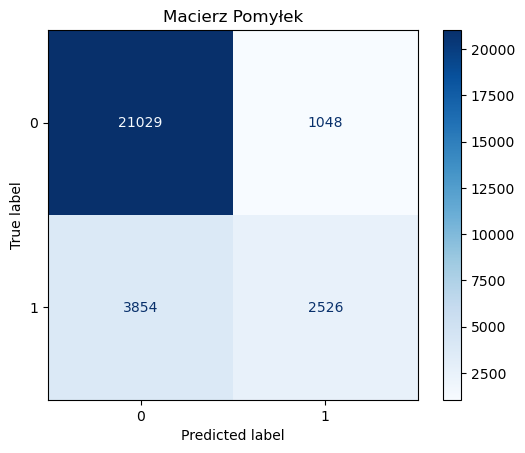

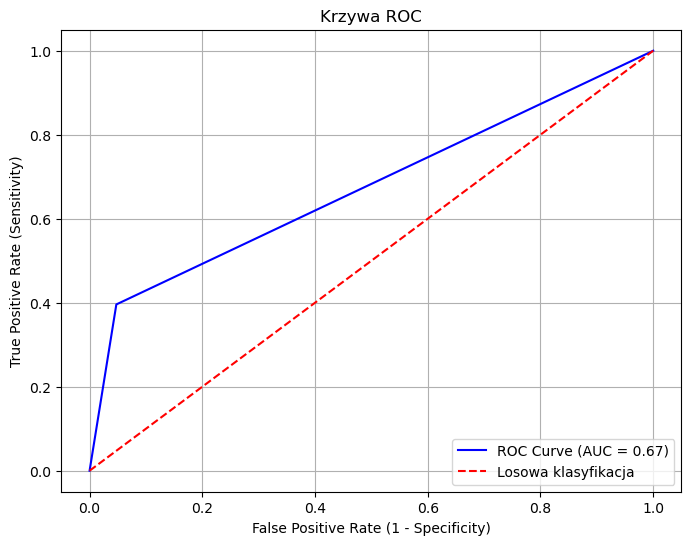

In [430]:
best_model = region_models[best_region]
y_pred_best_model = best_model.predict(X_test_all)

Y_test_all_numeric = pd.Series(Y_test_all).map({'Yes': 1, 'No': 0}).values
y_pred_best_model_numeric = pd.Series(y_pred_best_model).map({'Yes': 1, 'No': 0}).values

accuracy_best, sensitivity_best, specificity_best = calculate_metrics(Y_test_all_numeric, y_pred_best_model_numeric)

print("\nWyniki najlepszego modelu krajowego:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Sensitivity: {sensitivity_best:.4f}")
print(f"Specificity: {specificity_best:.4f}")
plot_confusion_matrix(Y_test_all_numeric, y_pred_best_model_numeric, labels=[0, 1])
plot_roc_curve(Y_test_all_numeric, y_pred_best_model_numeric)

#### Wnioski 

Porównanie skuteczności modeli regionalnych na zbiorze krajowym pokazuje, że modele trenowane na lokalnych danych mogą osiągać 
wysoką skuteczność w swoich regionach, ale ich zdolność generalizacji na dane spoza regionu jest ograniczona. Wynika to z faktu, 
że lokalne modele są dostosowane do specyficznych cech regionu, takich jak klimat czy sezonowość, które mogą nie być 
reprezentatywne dla innych obszarów. W efekcie, skuteczność modelu na zbiorze krajowym może być niższa niż na danych lokalnych, 
co wskazuje na ograniczoną uniwersalność takich modeli.

Budowanie modeli w oparciu o lokalne dane może być dobrym rozwiązaniem w sytuacjach, gdy dane uczące są ograniczone i istnieje 
potrzeba stworzenia modeli specyficznych dla danego regionu. Taki podejście pozwala na lepsze dopasowanie modelu do lokalnych 
warunków i może zmniejszyć wymagania dotyczące ilości danych uczących. Jednakże, takie modele mogą mieć ograniczoną zdolność do 
generalizacji na inne regiony, co może być problematyczne w przypadku potrzeby zastosowania modelu na większą skalę. Dlatego 
w zależności od celu analizy, należy rozważyć kompromis między lokalną skutecznością a zdolnością do generalizacji.